In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
from scipy.optimize import minimize
import matplotlib.pyplot as plt
%matplotlib inline
symbols = ['GOOGL', 'TSLA', 'FB', 'AMZN', 'AAPL', 'MSFT', 'VOD',  'ADBE', 'NVDA', 'CRM' ]
all_stocks = pd.DataFrame()
for symbol in symbols:
    tmp_close = yf.download(symbol, 
                      start='2019-11-07', 
                      end='2020-11-07', 
                      progress=False)['Close']
    all_stocks = pd.concat([all_stocks, tmp_close], axis=1)
all_stocks.columns=symbols
all_stocks

Exception in thread Thread-4:
Traceback (most recent call last):
  File "/Users/sergiogago/opt/anaconda3/envs/qiskit24/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/Users/sergiogago/opt/anaconda3/envs/qiskit24/lib/python3.8/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/sergiogago/opt/anaconda3/envs/qiskit24/lib/python3.8/site-packages/multitasking/__init__.py", line 102, in _run_via_pool
    return callee(*args, **kwargs)
  File "/Users/sergiogago/opt/anaconda3/envs/qiskit24/lib/python3.8/site-packages/yfinance/multi.py", line 167, in _download_one_threaded
    data = _download_one(ticker, start, end, auto_adjust, back_adjust,
  File "/Users/sergiogago/opt/anaconda3/envs/qiskit24/lib/python3.8/site-packages/yfinance/multi.py", line 179, in _download_one
    return Ticker(ticker).history(period=period, interval=interval,
  File "/Users/sergiogago/opt/anaconda3/envs/qiskit24/lib/python3.8/site-packages/yf

KeyboardInterrupt: 

<AxesSubplot:>

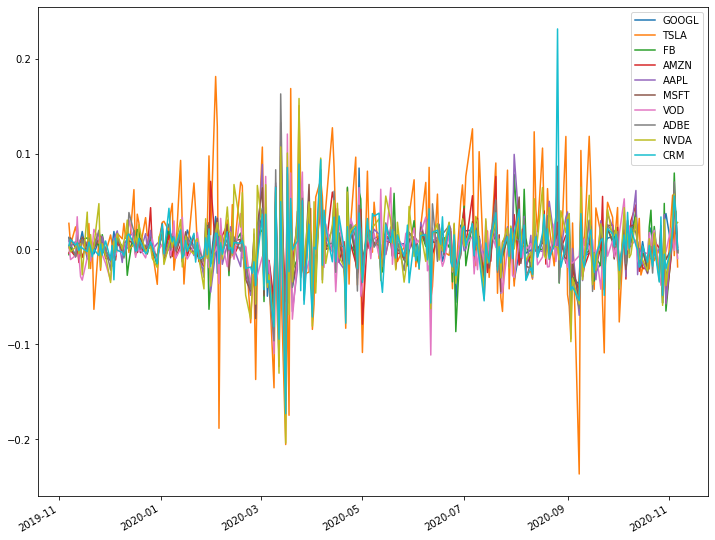

In [ ]:
returns = np.log(all_stocks/all_stocks.shift(1)).dropna(how="any")
returns.plot(figsize=(12,10))


In [ ]:
# Optimizer to minimize the risk
def objective(weights): 
    weights = np.array(weights)
    return weights.dot(returns.cov()).dot(weights.T)
    
# The constraints
cons = (# The weights must sum up to one.
        {"type":"eq", "fun": lambda x: np.sum(x)-1}, 
        # This constraints says that the inequalities (ineq) must be non-negative.
        # The expected daily return of our portfolio and we want to be at greater than 0.002352
        {"type": "ineq", "fun": lambda x: np.sum(returns.mean()*x)-0.003})
# Every stock can get any weight from 0 to 1
bounds = tuple((0,1) for x in range(returns.shape[1]))
# Initialize the weights with an even split
# In out case each stock will have 10% at the beginning
guess = [1./returns.shape[1] for x in range(returns.shape[1])]
optimized_results = minimize(objective, guess, method = "SLSQP", bounds=bounds, constraints=cons)
optimized_results

     fun: 0.0007596800853378743
     jac: array([0.00113375, 0.00236566, 0.00127447, 0.0010218 , 0.00137465,
       0.00137397, 0.00097843, 0.00144561, 0.00174113, 0.0014457 ])
 message: 'Optimization terminated successfully'
    nfev: 22
     nit: 2
    njev: 2
  status: 0
 success: True
       x: array([0.08447057, 0.17051382, 0.09077398, 0.10128927, 0.10099533,
       0.09145521, 0.04536969, 0.09705495, 0.12378042, 0.09429676])

In [8]:
weights = optimized_results.x


In [5]:
np.sum(returns.mean()*optimized_results.x)

0.0030000000008646877

In [7]:
returns.mean()*optimized_results.x

GOOGL    0.000103
TSLA     0.001270
FB       0.000153
AMZN     0.000245
AAPL     0.000245
MSFT     0.000159
VOD     -0.000072
ADBE     0.000208
NVDA     0.000505
CRM      0.000184
dtype: float64

In [ ]:
assets = pd.concat([ind_er, ann_sd], axis=1) # Creating a table for visualising returns and volatility of assets
assets.columns = ['Returns', 'Volatility']
assets

In [12]:
cov_matrix = all_stocks.pct_change().apply(lambda x: np.log(1+x)).cov()

In [13]:
cov_matrix

,GOOGL,TSLA,FB,AMZN,AAPL,MSFT,VOD,ADBE,NVDA,CRM
GOOGL,0.000582,0.000643,0.000553,0.000392,0.000536,0.000574,0.000416,0.000587,0.000679,0.000548
TSLA,0.000643,0.003029,0.000674,0.000629,0.000831,0.000823,0.000615,0.000826,0.001072,0.000925
FB,0.000553,0.000674,0.000818,0.000460,0.000642,0.000604,0.000419,0.000660,0.000730,0.000652
AMZN,0.000392,0.000629,0.000460,0.000564,0.000486,0.000478,0.000270,0.000526,0.000572,0.000476
AAPL,0.000536,0.000831,0.000642,0.000486,0.000838,0.000678,0.000423,0.000680,0.000832,0.000617
MSFT,0.000574,0.000823,0.000604,0.000478,0.000678,0.000751,0.000464,0.000717,0.000842,0.000669
VOD,0.000416,0.000615,0.000419,0.000270,0.000423,0.000464,0.000796,0.000481,0.000571,0.000480
ADBE,0.000587,0.000826,0.000660,0.000526,0.000680,0.000717,0.000481,0.000881,0.000855,0.000762
NVDA,0.000679,0.001072,0.000730,0.000572,0.000832,0.000842,0.000571,0.000855,0.001311,0.000787
CRM,0.000548,0.000925,0.000652,0.000476,0.000617,0.000669,0.000480,0.000762,0.000787,0.001006


In [26]:
p_ret = [] # Define an empty array for portfolio returns
p_vol = [] # Define an empty array for portfolio volatility
p_weights = [] # Define an empty array for asset weights

mean = returns.mean()
num_assets = len(symbols)
num_portfolios = 10

for portfolio in range(num_portfolios):
    weights = np.random.random(num_assets)
    weights = weights/np.sum(weights)
    p_weights.append(weights)
    sim_returns = np.dot(weights, mean) # Returns are the product of individual expected returns of asset and its 
                                      # weights 
    p_ret.append(sim_returns)
    var = cov_matrix.mul(weights, axis=0).mul(weights, axis=1).sum().sum()# Portfolio Variance
    sd = np.sqrt(var) # Daily standard deviation
    ann_sd = sd*np.sqrt(250) # Annual standard deviation = volatility
    p_vol.append(ann_sd)

In [27]:
data = {'Returns':p_ret, 'Volatility':p_vol}

for counter, symbol in enumerate(all_stocks.columns.tolist()):
    #print(counter, symbol)
    data[symbol+' weight'] = [w[counter] for w in p_weights]

In [28]:
portfolios  = pd.DataFrame(data)
portfolios


,Returns,Volatility,GOOGL weight,TSLA weight,FB weight,AMZN weight,AAPL weight,MSFT weight,VOD weight,ADBE weight,NVDA weight,CRM weight
0,0.0,0.445207,0.034531,0.184984,0.177771,0.023231,0.032238,0.127263,0.100769,0.056005,0.133492,0.129716
1,0.0,0.391802,0.113925,0.124063,0.194393,0.164857,0.014980,0.111505,0.171941,0.019991,0.049942,0.034403
2,0.0,0.411916,0.116734,0.100009,0.103995,0.113618,0.118065,0.085870,0.068901,0.080535,0.129609,0.082664
3,0.0,0.428322,0.149151,0.224766,0.149835,0.025553,0.032060,0.032756,0.232103,0.134412,0.007117,0.012248
4,0.0,0.433229,0.094496,0.140219,0.136863,0.021115,0.052468,0.180469,0.076757,0.043221,0.148492,0.105899
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.0,0.394483,0.078267,0.102430,0.163669,0.235403,0.195729,0.012747,0.057084,0.118751,0.019347,0.016574
9996,0.0,0.390089,0.040653,0.036434,0.124011,0.150982,0.126063,0.141477,0.134228,0.074900,0.084025,0.087228
9997,0.0,0.397653,0.019328,0.007925,0.117672,0.131334,0.081930,0.111193,0.145579,0.083820,0.152938,0.148282
9998,0.0,0.422201,0.092337,0.087210,0.073001,0.005825,0.117315,0.084472,0.164706,0.191470,0.178955,0.004708


<AxesSubplot:xlabel='Volatility', ylabel='Returns'>

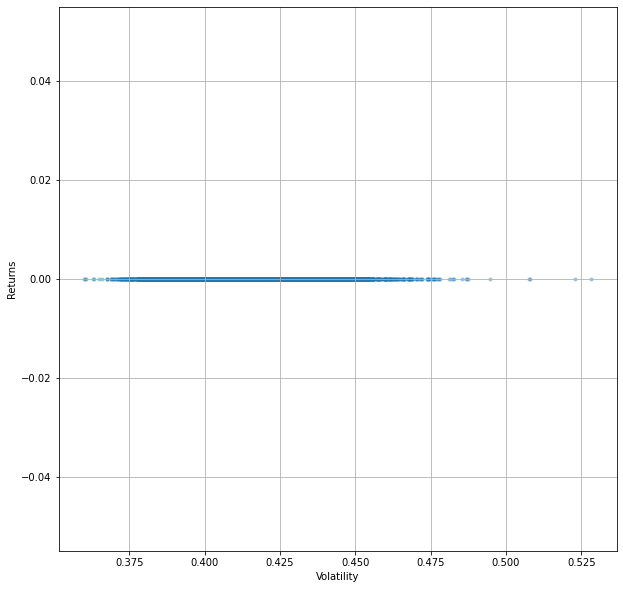

In [29]:
portfolios.plot.scatter(x='Volatility', y='Returns', marker='o', s=10, alpha=0.3, grid=True, figsize=[10,10])